In [2]:
import pickle as pkl
import numpy as np 

import matplotlib.pyplot as plt 
import librosa



(256, 256) 1


/tmp/ipykernel_13442/2885417012.py:14: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  img = librosa.display.specshow(librosa.amplitude_to_db(tmp,ref=np.max))


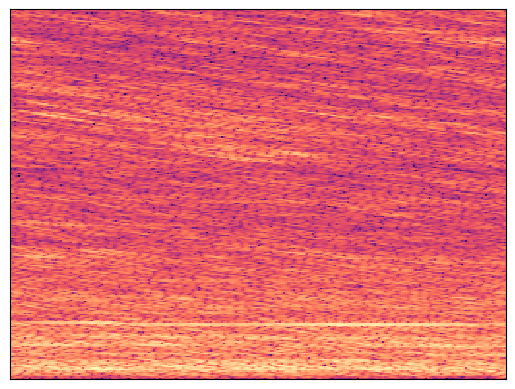

In [26]:
pkl_path = "../data/features/stft/test_sr_16e3_bearing_crop4_featurestft_s04.pkl"
# pkl_path = "../data/features/classes/train_sr_16e3_bearing_crop4_featuremfcc_s04.pkl"

with open(pkl_path, 'rb') as f:
    data = pkl.load(f)

index = 
tmp = data[index][1]
label = data[index][-1]

tmp = np.resize(tmp, (256, 256))
print(np.shape(tmp), label)

img = librosa.display.specshow(librosa.amplitude_to_db(tmp,ref=np.max))

In [10]:
label = [i[-1] for i in data]

In [11]:
import numpy as np 
features = [[i[0], i[1], i[2]] for i in data]
# features = [[np.shape(i[0]), np.shape(i[1]), np.shape(i[2])] for i in features]
features

[[(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126), (128, 126)],
 [(128, 126), (128, 126),

In [4]:
[label.count(i) for i in list(set(label))]

[990]

In [5]:
tmp = "./data/features/classes/train_sr_16e3_ToyCar_crop4_featuremfccADD_labelx3.pkl"

tmp.split("/")[-1].split("_")[3]

'ToyCar'

In [5]:
list(range(10))[1:5]

[1, 2, 3, 4]

In [2]:
float(format(1.23456789, '.2f'))

1.23

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from torchviz import make_dot

# import librosa 
import numpy as np

from tqdm import tqdm 
from glob import glob 
from make_dataset import CustomDataset
from architecture.ae_ncp import ncp

torch.manual_seed(7777)
np.random.seed(7777)

def accuracy(predictions, labels):
    _, predicted_classes = torch.max(predictions, dim=1)  
    correct = (predicted_classes == labels).float()  
    acc = correct.sum() / len(correct) 
    return acc

def dataset_prep(path, batch_size, shuffle=True, mode="train"):
    dataset = CustomDataset(
        pkl_path = path, 
        domain=1,
        mode="test"
    )

    train_loader = DataLoader( 
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
    ) 

    return train_loader

def model_test(batch_size, dataset_path, model, criterion = nn.CrossEntropyLoss(), threshold = 0.4):
    # Load dataset
    train_loader = dataset_prep(dataset_path, batch_size, shuffle=False, mode="test")

    criterion = nn.CrossEntropyLoss()
    ae_criterion = nn.MSELoss()

    model = torch.load("./saved_model/test_save.pkl")

    # Auto config model to fit w/ gpu or cpu 
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # print("Running on :", device)

    model.to(device)
    # print("============================ Test / Validation mode ============================")
    total_anomaly = 0
    total_correct = 0
    total_samples = 0
    model_prediction = []
    label_save = []
    for img1, img2, img3, label in train_loader:
        # Make prediction for loss calculation
        img1 = img1.to(device)
        img2 = img2.to(device)
        img3 = img3.to(device)

        label = label.to(device)
        label = label.squeeze(dim=-1) 
        label_save.append(label.item())

        # print("="* 20, "DEBUG", "="* 20)
        # print(img1.size())
        # print(img2.size())
        # print(img3.size())
        # print("="* 20, "DEBUG", "="* 20)

        # Fitting
        d1, d2, d3, pred = model(img1, img2, img3)

        # Loss calculation
        ae1_loss = ae_criterion(d1, img1) 
        ae2_loss = ae_criterion(d2, img2) 
        ae3_loss = ae_criterion(d3, img3) 
        lnn_loss = criterion(pred, label) 
        total_loss = ae1_loss + ae2_loss + ae3_loss + lnn_loss
        

        # total_loss_round = float(format(total_loss, '.3f'))
        # print(total_loss.item(),"  Label :", label.item())
        # Accuracy calculation
        if total_loss.item() > threshold and label == 1: 
            total_anomaly += 1
            model_prediction.append(1)
        elif total_loss.item() <= threshold and label == 0: 
            total_anomaly += 1
            model_prediction.append(0)
        else: 
            if label.item() == 0: model_prediction.append(1)
            else: model_prediction.append(0)


        total_correct += (pred.argmax(1) == label).type(torch.float).sum().item()
        total_samples += label.size(0)

    # Accuracy calculation for batch
    acc = total_correct / total_samples
    anomaly_acc = total_anomaly / total_samples

    fpr, tpr, thresholds = roc_curve(label_save, model_prediction)

    roc_auc = roc_auc_score(label_save, model_prediction)

    print("val Accuracy:", acc * 100, end="  ")
    print("roc_auc:", roc_auc, end="  ")
    print("anomaly_acc:", anomaly_acc * 100, end="  ")
    print("val loss:", total_loss.item(), end="  ")
    print("threshold :", threshold)
    print("thresholds :", thresholds)
    print("="*50)
    return acc, anomaly_acc, total_loss.item(), threshold, fpr, tpr

model = ncp()
dataset_path = "./data/features/stft/train_sr_16e3_valve_crop4_featurestft_s04.pkl"

with torch.no_grad():
    acc, anomaly_acc, total_loss, threshold, fpr, tpr = model_test(batch_size = 1, dataset_path = dataset_path.replace("train", "test"), model = model)

alloc!
val Accuracy: 50.0  roc_auc: 0.5  anomaly_acc: 50.0  val loss: 1.9378451108932495  threshold : 0.4
thresholds : [inf  1.]
